In [1]:
def calculate_final_prediction(data, ID, conf_threshold = 0.5):
    predictions_logit = [row[2] for row in data if row[0] == ID]
    mean_logit = sum(predictions_logit) / len(predictions_logit)

    if mean_logit >= conf_threshold:
        return '1'
    else:
        return '0'

In [3]:
def calculate_binary_metrics(tp, fp, tn, fn):
    """
    Calculate accuracy, precision, recall, and F1-score for binary classification.
    
    Args:
        tp (int): True Positives
        fp (int): False Positives  
        tn (int): True Negatives
        fn (int): False Negatives
        
    Returns:
        dict: Dictionary containing accuracy, precision, recall, and f1_score
    """
    
    # Calculate accuracy
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    
    # Calculate precision (handle division by zero)
    if tp + fp == 0:
        precision = 0.0
    else:
        precision = tp / (tp + fp)
    
    # Calculate recall (handle division by zero)
    if tp + fn == 0:
        recall = 0.0
    else:
        recall = tp / (tp + fn)
    
    # Calculate F1-score (handle division by zero)
    if precision + recall == 0:
        f1_score = 0.0
    else:
        f1_score = 2 * (precision * recall) / (precision + recall)
    
    return accuracy, precision, recall, f1_score

In [4]:
def calculate_TPR_FPR(TP, FP, TN, FN):

    TPR = TP/(TP+FN) if (TP+FN) > 0 else 1.0
    FPR = FP/(FP+TN) if (FP+TN) > 0 else 0.0
    return TPR, FPR

In [10]:
import numpy as np
import csv

exps = ['erosion', 'flattening', 'genSclerosis', 'OA', 'osteophyte', 'subCyst']

for exp in exps:
    data_path = rf'd:\Kananat\Data\training_dataset_2D\Multiview\{exp}_multiview\val_grouped\predictions.txt'
    save_path = rf'd:\Kananat\Data\training_dataset_2D\Multiview\{exp}_multiview\val_grouped\metrics.csv'

    with open(data_path, 'r') as file:
        csv_reader = csv.reader(file)

        # data = ['ID', 'real', 'predicted_class', 'confidence']
        data = list(csv_reader)

    # data = ['ID', 'real', 'logit']
    data = [[row[0], row[1], (1-float(row[2]))*(1-float(row[3])) + float(row[2])*float(row[3])] for row in data]

    step_size = 0.01
    conf_list = np.arange(0, 1+step_size, step_size).tolist()

    ID_list = list(set([(row[0], row[1]) for row in data]))

    results = []
    for conf in conf_list:
        realANDpredict = []
        for ID, real in ID_list:
            predicted = calculate_final_prediction(data, ID, conf_threshold = conf)
            realANDpredict.append([real, predicted])

        TP, FP, TN, FN = 0, 0, 0, 0
        for real, predicted in realANDpredict:
            if real == '1' and predicted =='1':
                TP += 1
            elif real == '0' and predicted == '1':
                FP += 1
            elif real == '0' and predicted == '0':
                TN += 1
            elif real == '1' and predicted == '0':
                FN += 1

        accuracy, precision, recall, f1_score = calculate_binary_metrics(TP, FP, TN, FN)
        TPR, FPR = calculate_TPR_FPR(TP, FP, TN, FN)
        results.append([conf, accuracy, precision, recall, f1_score, TPR, FPR, TP, FP, TN, FN])

    with open(save_path, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['conf_threshold', 'accuracy', 'precision', 'recall', 'f1_score', 'TPR', 'FPR', 'TP', 'FP', 'TN', 'FN'])
        writer.writerows(results)

AUC Results:
erosion: 0.775
flattening: 0.455
genSclerosis: 0.863
OA: 0.947
osteophyte: 0.868
subCyst: 0.766


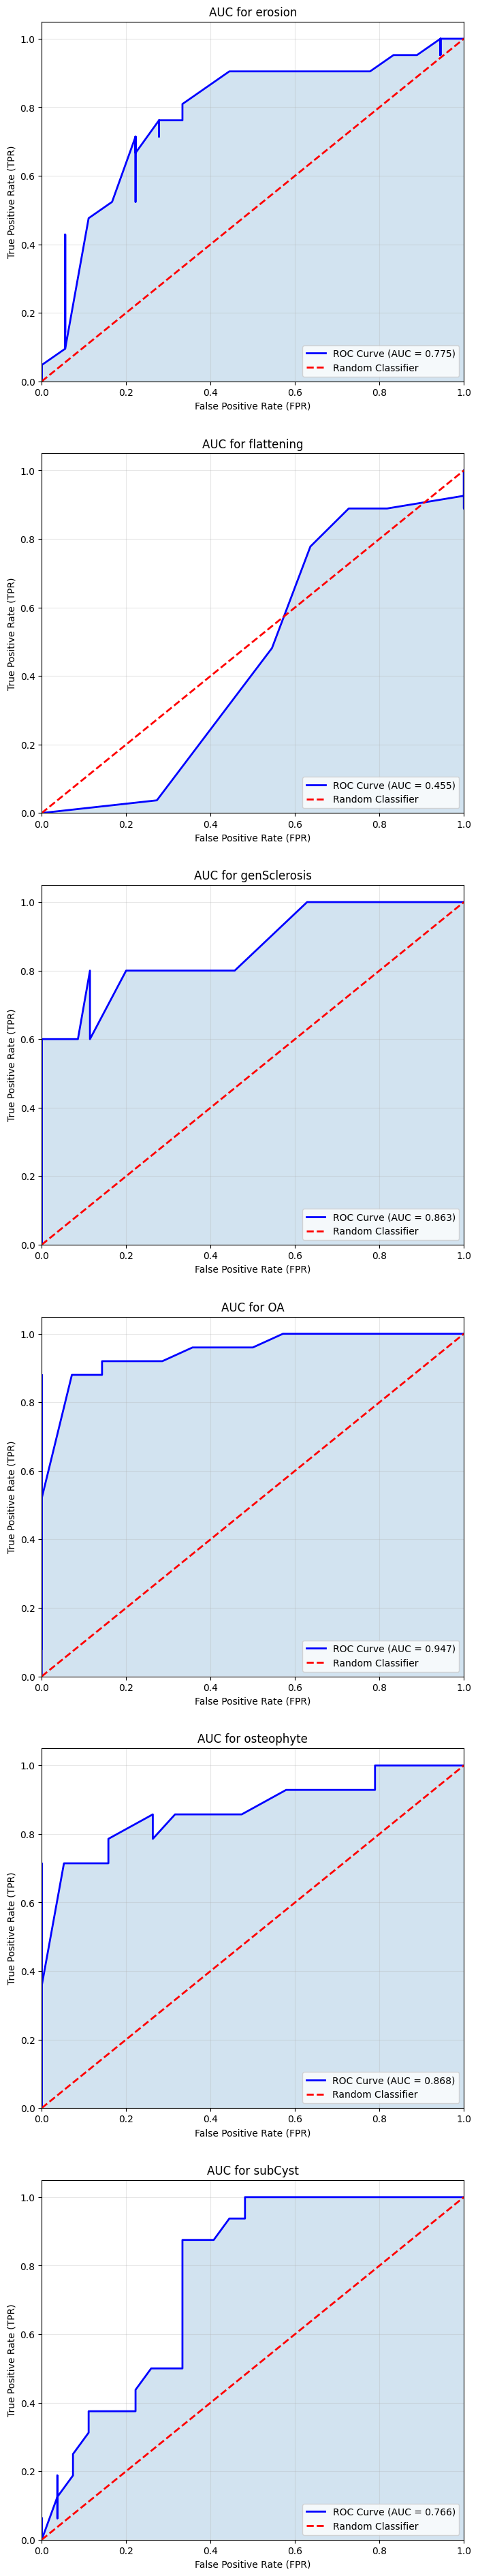

In [45]:
exps = ['erosion', 'flattening', 'genSclerosis', 'OA', 'osteophyte', 'subCyst']

from sklearn.metrics import auc
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(8, 48))

results = {}
for i, exp in enumerate(exps):
    data_path = rf'd:\Kananat\Data\training_dataset_2D\Multiview\{exp}_multiview\test_grouped\metrics.csv'
    with open(data_path, 'r') as file:
        csv_reader = csv.reader(file)

        # data = [conf, accuracy, precision, recall, f1_score, TPR, FPR, TP, FP, TN, FN]
        data = list(csv_reader)

    data = data[1:]

    tpr_list = [float(row[5]) for row in data]
    fpr_list = [float(row[6]) for row in data]
        
    # Convert to numpy arrays for easier manipulation
    fpr = np.array(fpr_list)
    tpr = np.array(tpr_list)

    # Sort by FPR to ensure proper order for AUC calculation
    sorted_indices = np.argsort(fpr)
    fpr_sorted = fpr[sorted_indices]
    tpr_sorted = tpr[sorted_indices]

    # Calculate AUC using trapezoidal rule
    auc_value = auc(fpr_sorted, tpr_sorted)

    # Store the results
    results[exp] = auc_value

    axes[i].plot(fpr_sorted, tpr_sorted, 'b-', linewidth=2, label=f'ROC Curve (AUC = {auc_value:.3f})')
    axes[i].plot([0, 1], [0, 1], 'r--', linewidth=2, label='Random Classifier')
    axes[i].fill_between(fpr_sorted, tpr_sorted, alpha=0.2)
    axes[i].set_xlim([0.0, 1.0])
    axes[i].set_ylim([0.0, 1.05])
    axes[i].set_xlabel('False Positive Rate (FPR)')
    axes[i].set_ylabel('True Positive Rate (TPR)')
    axes[i].set_title(f'AUC for {exp}')
    axes[i].legend(loc="lower right")
    axes[i].grid(True, alpha=0.3)

print("AUC Results:")
for exp, auc_value in results.items():
    print(f"{exp}: {auc_value:.3f}")

# Create the plot
plt.show()

In [33]:
exps = ['erosion', 'flattening', 'genSclerosis', 'OA', 'osteophyte', 'subCyst']

from sklearn.metrics import auc
import matplotlib.pyplot as plt

best_threshold_val = {}
for exp in exps:
    data_path = rf'd:\Kananat\Data\training_dataset_2D\Multiview\{exp}_multiview\val_grouped\metrics.csv'
    with open(data_path, 'r') as file:
        csv_reader = csv.reader(file)

        # data = [conf, accuracy, precision, recall, f1_score, TPR, FPR, TP, FP, TN, FN]
        data = list(csv_reader)

    data = data[1:]

    best_f1 = 0
    for row in data:
        f1 = float(row[4])
        if f1 >= best_f1:
            best_f1 = f1
            best_metrics = row
    best_threshold_val[exp] = best_metrics

print("Best conf threshold on Validation Set:")
for exp, metrics in best_threshold_val.items():
    print(f"{exp}")
    print(f"    Conf Threshold: {float(metrics[0]):.2f}")
    print(f"    Accuracy:       {float(metrics[1]):.3f}")
    print(f"    Precision:      {float(metrics[2]):.3f}")
    print(f"    Recall:         {float(metrics[3]):.3f}")
    print(f"    F1 Score:       {float(metrics[4]):.3f}")
    print(f"    Confusion Matrix")
    print(f"             Predict[0]   Predict[1]")
    print(f"    Real[0]      {metrics[7]}           {metrics[8]}")
    print(f"    Real[1]      {metrics[10]}            {metrics[9]}\n")

Best conf threshold on Validation Set:
erosion
    Conf Threshold: 0.53
    Accuracy:       0.884
    Precision:      0.917
    Recall:         0.868
    F1 Score:       0.892
    Confusion Matrix
             Predict[0]   Predict[1]
    Real[0]      33           3
    Real[1]      5            28

flattening
    Conf Threshold: 0.57
    Accuracy:       0.574
    Precision:      0.574
    Recall:         1.000
    F1 Score:       0.729
    Confusion Matrix
             Predict[0]   Predict[1]
    Real[0]      39           29
    Real[1]      0            0

genSclerosis
    Conf Threshold: 0.14
    Accuracy:       0.870
    Precision:      0.583
    Recall:         0.636
    F1 Score:       0.609
    Confusion Matrix
             Predict[0]   Predict[1]
    Real[0]      7           5
    Real[1]      4            53

OA
    Conf Threshold: 0.54
    Accuracy:       0.896
    Precision:      0.971
    Recall:         0.846
    F1 Score:       0.904
    Confusion Matrix
             Predi

In [34]:
exps = ['erosion', 'flattening', 'genSclerosis', 'OA', 'osteophyte', 'subCyst']

from sklearn.metrics import auc
import matplotlib.pyplot as plt

results = {}
for exp in exps:
    data_path = rf'd:\Kananat\Data\training_dataset_2D\Multiview\{exp}_multiview\test_grouped\metrics.csv'
    with open(data_path, 'r') as file:
        csv_reader = csv.reader(file)

        # data = [conf, accuracy, precision, recall, f1_score, TPR, FPR, TP, FP, TN, FN]
        data = list(csv_reader)

    metrics_at_best_threshold = [row for row in data if row[0] == best_threshold_val[exp][0]]
    results[exp] = metrics_at_best_threshold[0]

print("Test Set Metrics at Best Validation Threshold:")
for exp, metrics in results.items():
    print(f"{exp}")
    print(f"    Conf Threshold: {float(metrics[0]):.2f}")
    print(f"    Accuracy:       {float(metrics[1]):.3f}")
    print(f"    Precision:      {float(metrics[2]):.3f}")
    print(f"    Recall:         {float(metrics[3]):.3f}")
    print(f"    F1 Score:       {float(metrics[4]):.3f}")
    print(f"    Confusion Matrix")
    print(f"             Predict[0]   Predict[1]")
    print(f"    Real[0]      {metrics[7]}           {metrics[8]}")
    print(f"    Real[1]      {metrics[10]}            {metrics[9]}\n")

Test Set Metrics at Best Validation Threshold:
erosion
    Conf Threshold: 0.53
    Accuracy:       0.744
    Precision:      0.762
    Recall:         0.762
    F1 Score:       0.762
    Confusion Matrix
             Predict[0]   Predict[1]
    Real[0]      16           5
    Real[1]      5            13

flattening
    Conf Threshold: 0.57
    Accuracy:       0.684
    Precision:      0.703
    Recall:         0.963
    F1 Score:       0.812
    Confusion Matrix
             Predict[0]   Predict[1]
    Real[0]      26           11
    Real[1]      1            0

genSclerosis
    Conf Threshold: 0.14
    Accuracy:       0.875
    Precision:      0.500
    Recall:         0.600
    F1 Score:       0.545
    Confusion Matrix
             Predict[0]   Predict[1]
    Real[0]      3           3
    Real[1]      2            32

OA
    Conf Threshold: 0.54
    Accuracy:       0.923
    Precision:      1.000
    Recall:         0.880
    F1 Score:       0.936
    Confusion Matrix
          